In [1]:
# Final Project - Analysing Urban Walkability

In [ ]:
---
format: 
  html:
    toc: true
execute:
  echo: true
---

### Walkability Analysis 

Intersection density reflects the compactness and connectivity of a street network, key indicators of walkability. A dense network minimizes unreachable areas, while high connectivity allows for multiple routing options.

Initially, the walkable network of the study area was downloaded using OSMnx, forming a graph of edges (paths) and nodes (intersections).

In [2]:
#| echo: true 
#| code-fold: true
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import os
import numpy as np
import rasterio as rio
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from skimage.exposure import equalize_adapthist
import matplotlib.pyplot as plt
import pandana

%matplotlib inline

In [3]:
#| echo: true 
#| code-fold: true
# Select city and crs
cityname = 'kisumu, kenya'
crs = 32636

In [4]:
#| echo: true 
#| code-fold: true
# Get graph by geocoding
graph = ox.graph_from_place(cityname, network_type="walk")

# Project graph
graph = ox.projection.project_graph(graph, to_crs=crs)

In [5]:
#| echo: true 
#| code-fold: true
# Simplify to get real intersections only
# (consolidate nodes within a distance from eachother)
graph_simplified = ox.simplification.consolidate_intersections(
    # Graph to simplify
    graph,
    # buffer around each node (project the graph beforehand)
    tolerance=5,
    # Get result as graph (False to get nodes only as gdf)
    rebuild_graph=True,
    # no dead ends
    dead_ends=False,
    # Reconnect (False to get intersections only)
    reconnect_edges=True
)

In [6]:
#| echo: true 
#| code-fold: true
# everything to gdfs
nodes, edges = ox.graph_to_gdfs(graph)
nodes_s, edges_s = ox.graph_to_gdfs(graph_simplified)

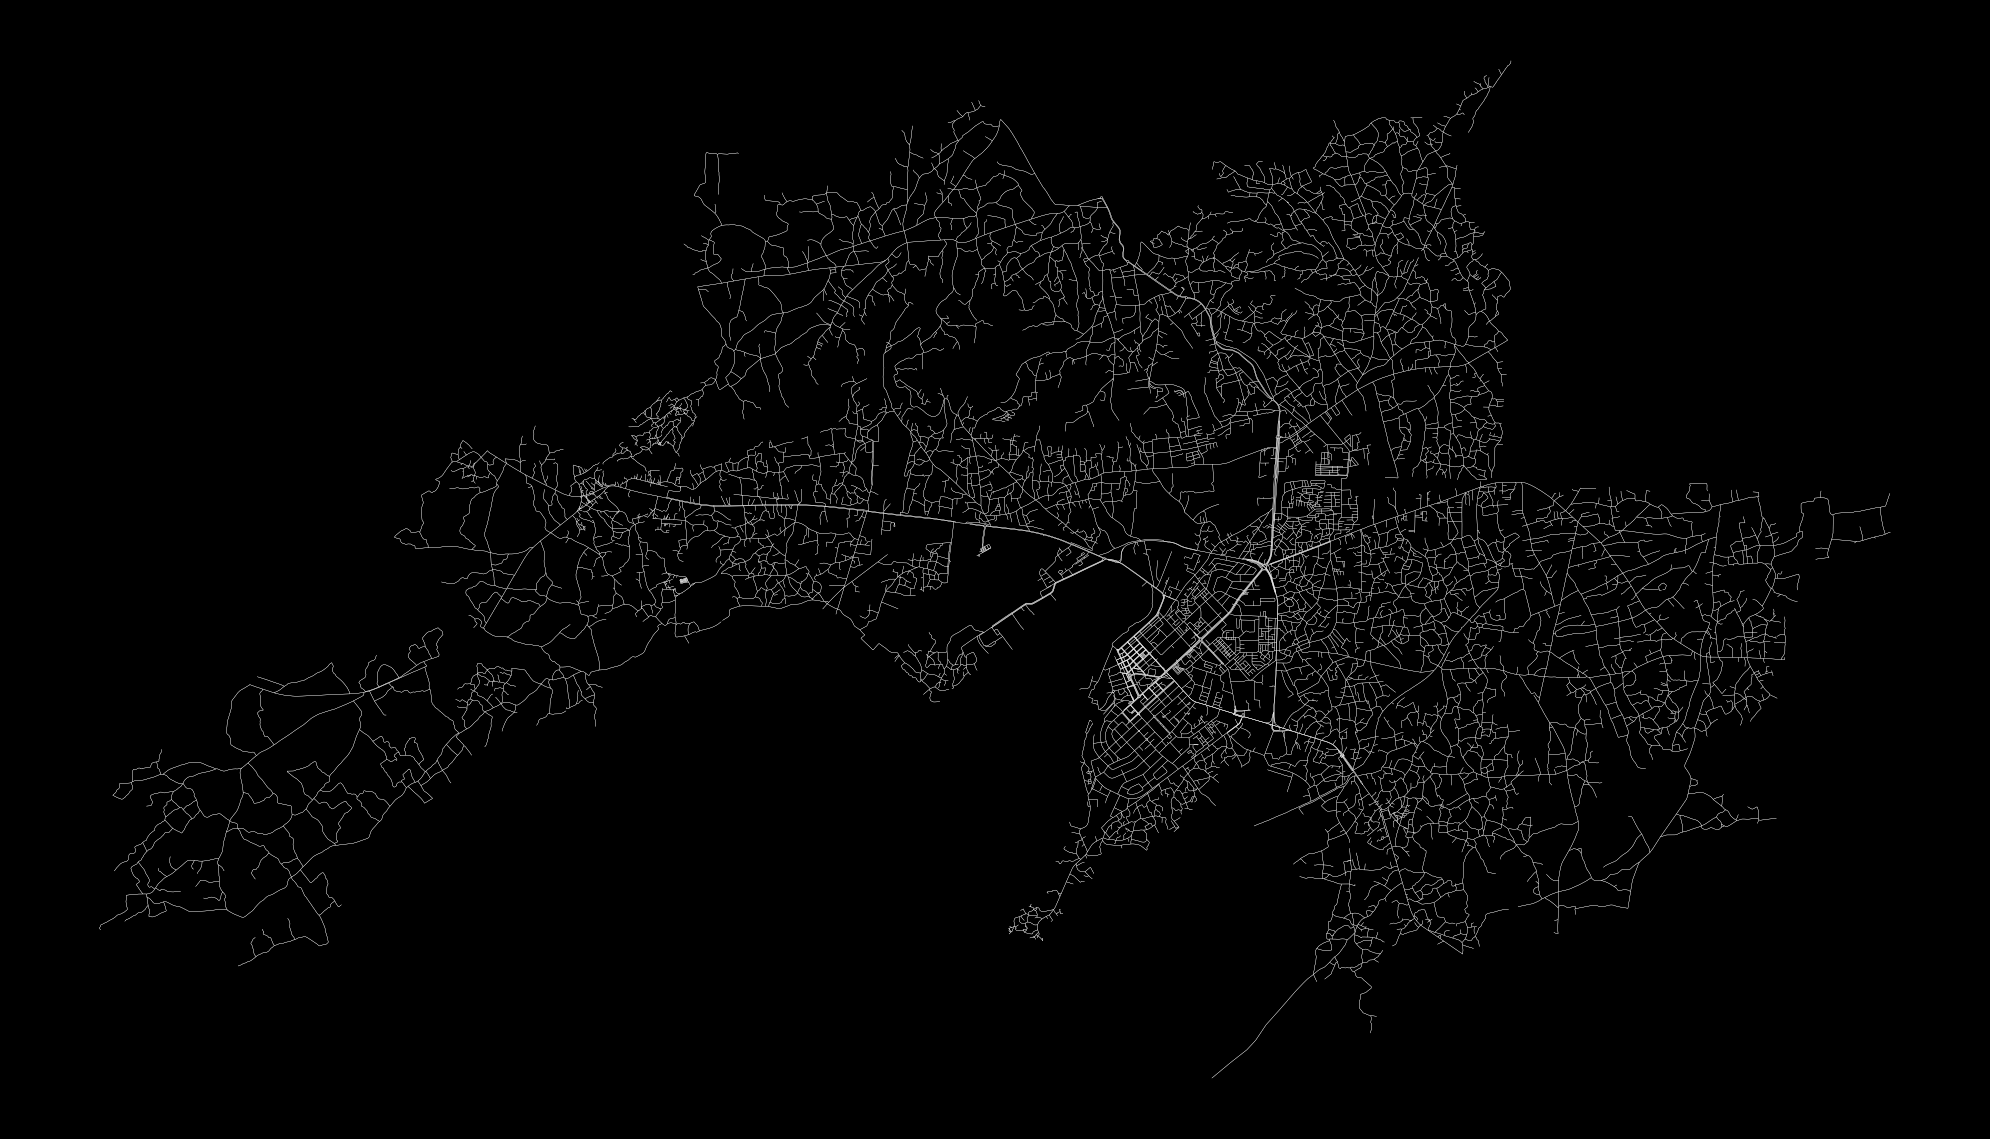

In [7]:
#| echo: false 
#| code-fold: true
# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor('black')

# Plot data
edges.plot(
    ax=ax,
    color='white',
    linewidth=0.2
)

# Tight layout
plt.tight_layout()

# Save
plt.savefig('./data/graph_overview.png')

To address overcomplexity, like minor discrepancies creating multiple nodes for a single intersection, the graph was simplified. Nodes within five meters were merged, and cul-de-sacs were removed, yielding a representation that more accurately reflects true intersections.

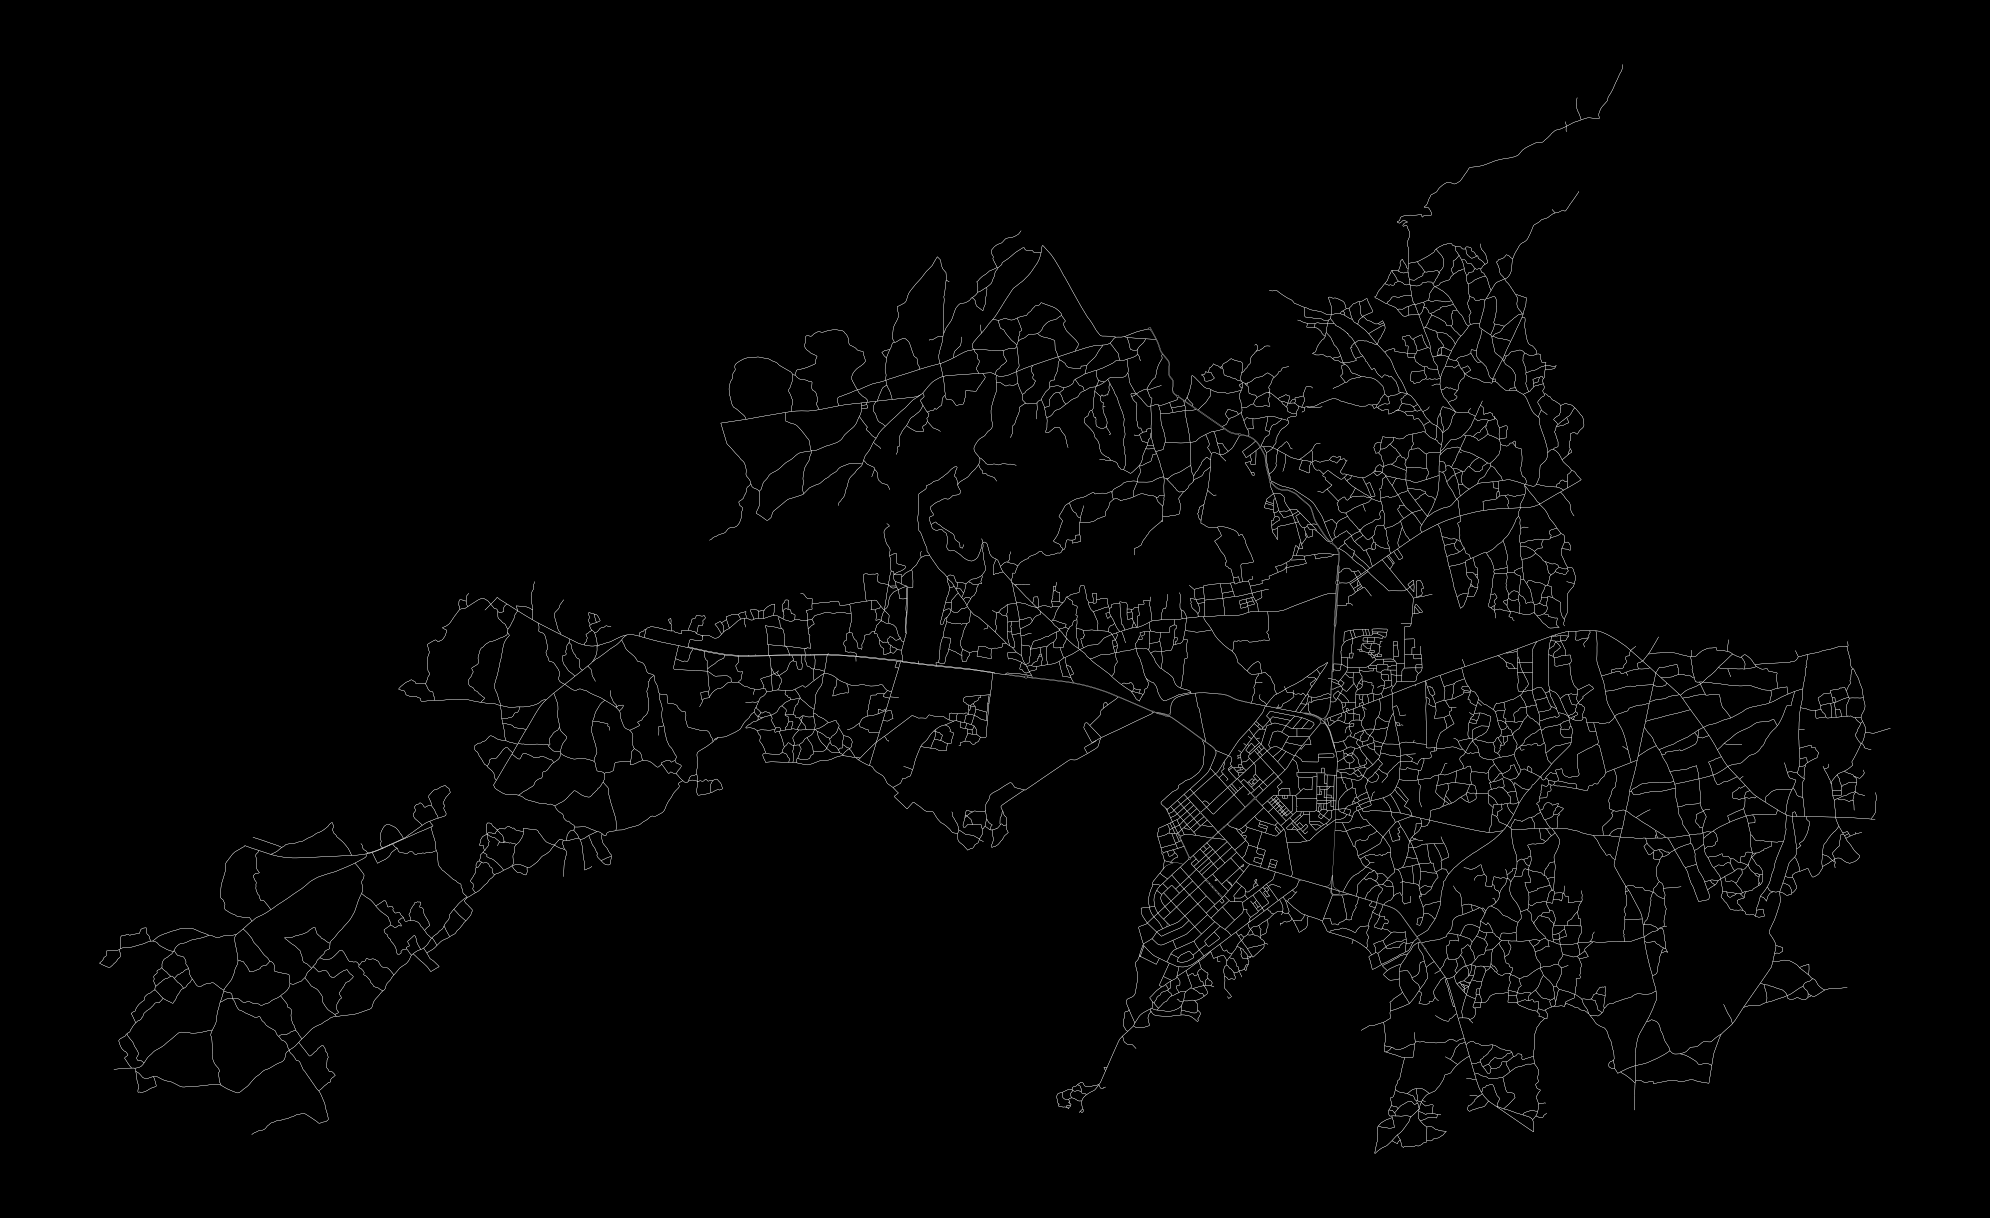

In [8]:
#| echo: false 
#| code-fold: true
# Select city and crs
cityname = 'Kisumu, Kenya'
crs = 'epsg:32636'  # Use the string format for CRS to avoid confusion

# Get graph by geocoding
graph = ox.graph_from_place(cityname, network_type="drive")

# Project graph
graph_projected = ox.project_graph(graph, to_crs=crs)

# Simplify the graph to get real intersections only
graph_simplified = ox.consolidate_intersections(
    graph_projected,
    tolerance=5,  # buffer in meters
    rebuild_graph=True,
    dead_ends=False,
    reconnect_edges=True
)

# Convert to geodataframes
nodes, edges = ox.graph_to_gdfs(graph_simplified)

# Setup plot
fig, ax = plt.subplots(figsize=(20, 15))
ax.set_axis_off()
fig.patch.set_facecolor('black')

# Plot drivable streets
edges.plot(
    ax=ax,
    color='white',
    linewidth=0.2
)

# Tight layout for saving
plt.tight_layout()

# Save the figure
plt.savefig('kisumu_drive_network.png', facecolor=fig.get_facecolor())

# Display the plot
plt.show()

In [9]:
#| echo: true 
#| code-fold: true
# Print info
print(
    'number of nodes:\n\noriginal graph: '+str(len(nodes))
    +'\nsimplified graph: '+str(len(nodes_s))
)

number of nodes:

original graph: 5319
simplified graph: 6153


The simplified reduced intersections and their mere agglomeration of nodes does little to convey meaningful information. To illustrate spatial variations in density, I employed Matplotlib’s hexbin function and explored Seaborn’s KDE plots for a more nuanced depiction.

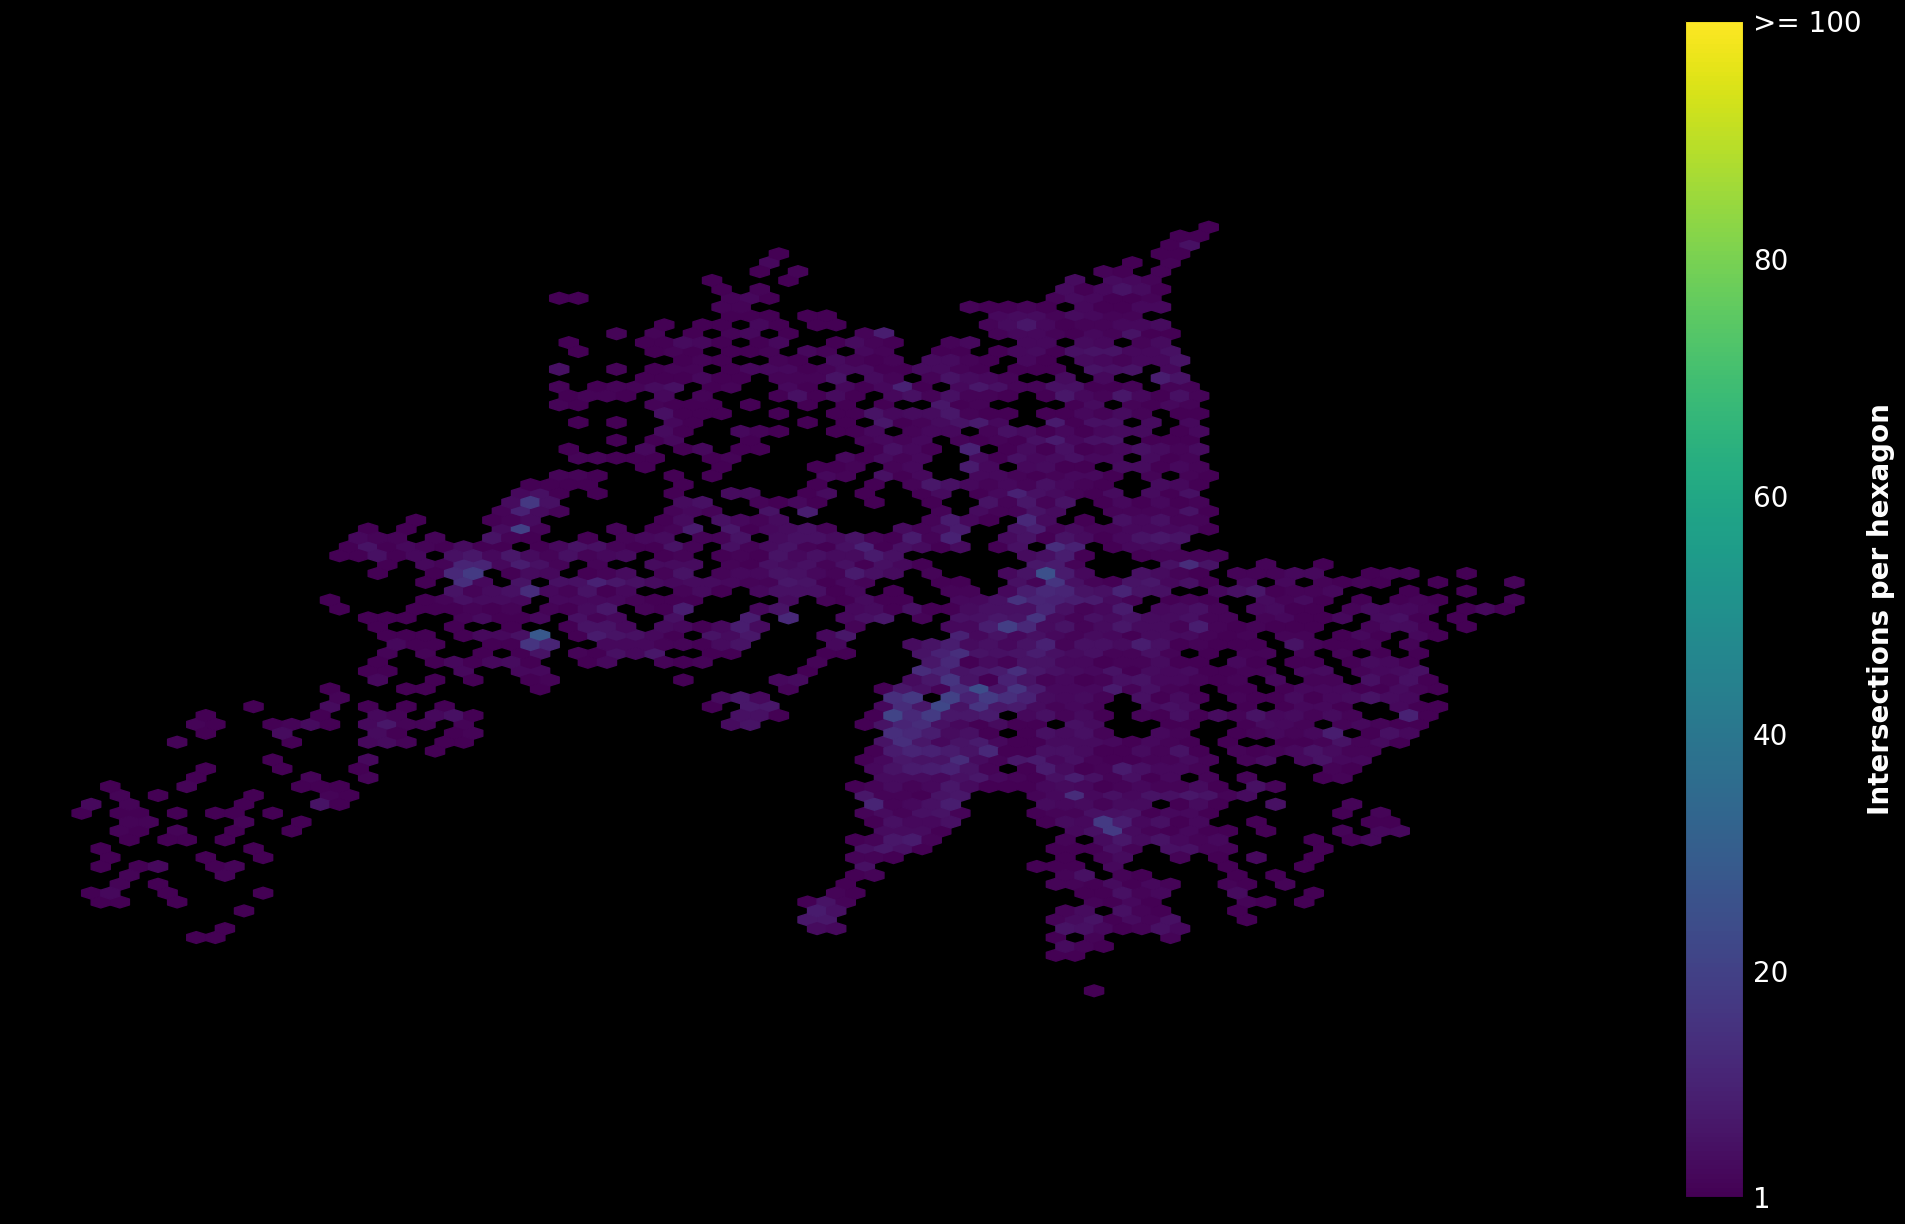

In [10]:
#| echo: false 
#| code-fold: true
# Set all text color to white
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor('black')

# Plot as hexbins
hb = ax.hexbin(
    x=nodes_s['x'],
    y=nodes_s['y'],
    gridsize=75,
    cmap='viridis',
    mincnt=1,
    vmax=100,
)

# Colorbar
cb = plt.colorbar(hb, ax=ax, shrink=0.8, ticks=[1, 20, 40, 60, 80, 100])
cb.ax.tick_params(color='none', labelsize=20)
cb.ax.set_yticklabels(['1', '20', '40', '60', '80', '>= 100'])
cb.set_label('Intersections per hexagon', fontsize=20, fontweight='bold')

# Tight layout
plt.tight_layout()

# Save
plt.savefig('./data/intersection_hexbin.png')

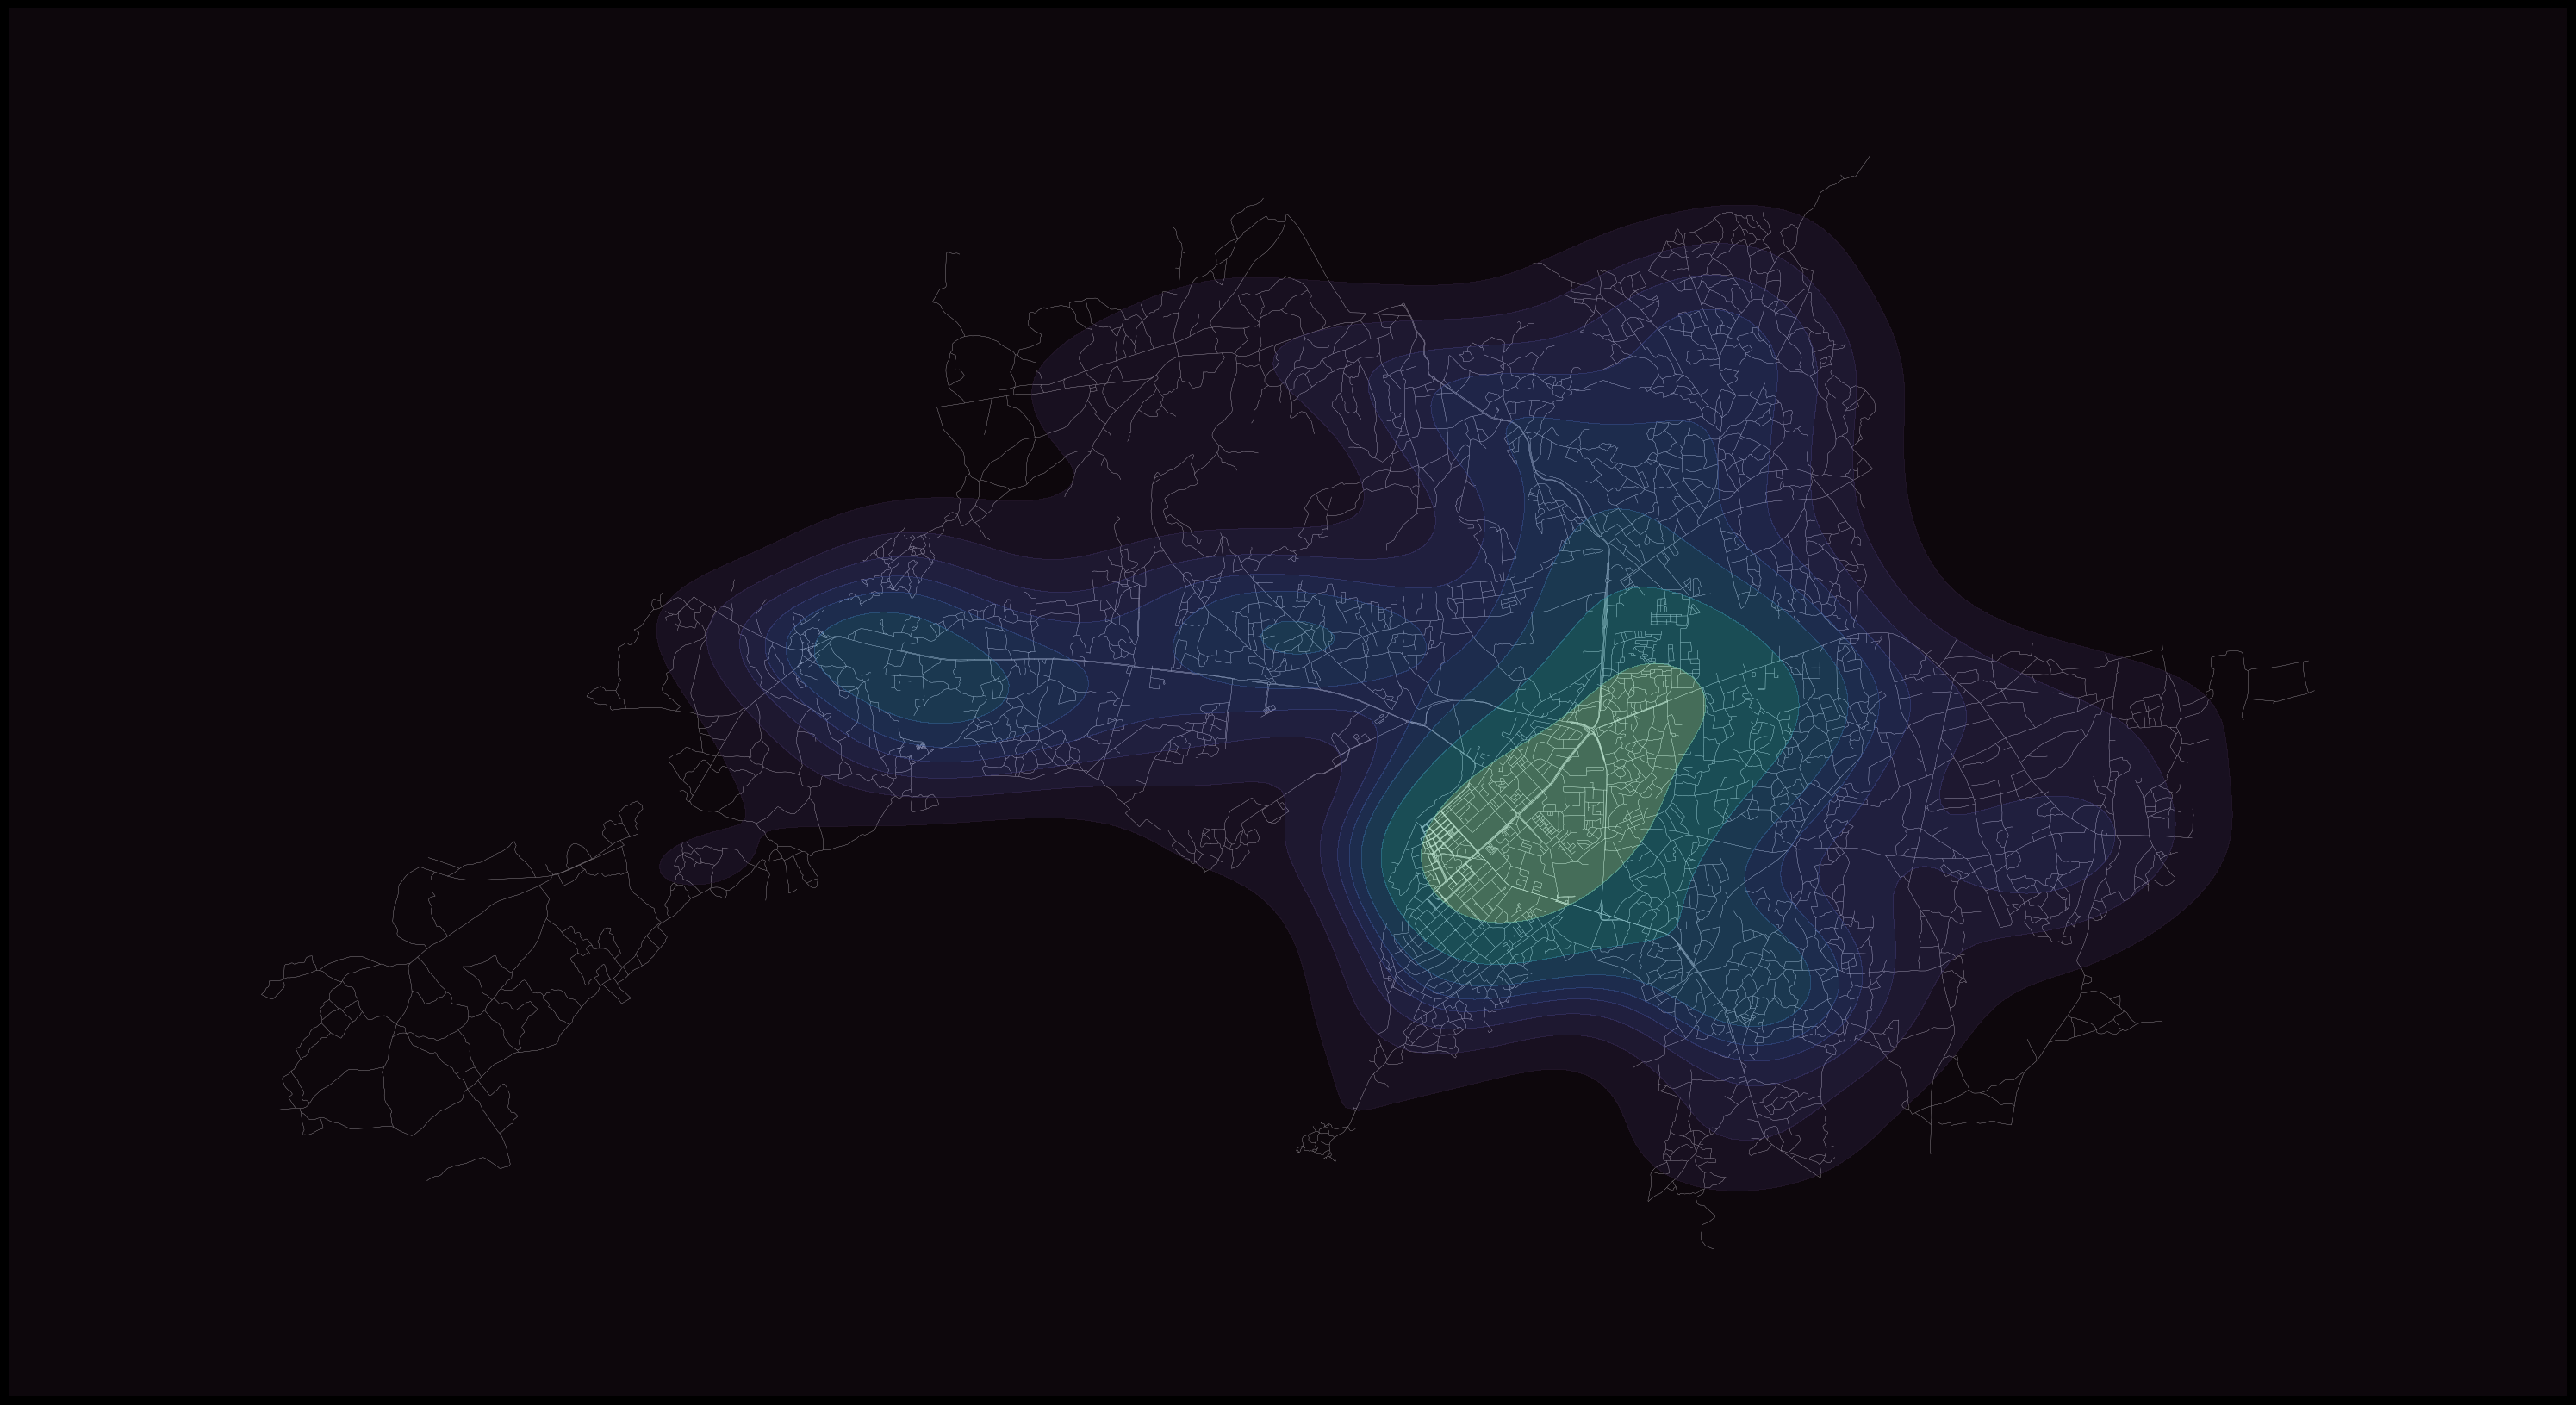

In [11]:
#| echo: false 
#| code-fold: true
# Setup plot
fig, ax = plt.subplots(figsize=(30,30))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor('black')

# Plot streets underneath
edges_s.plot(ax=ax, color=[1,1,1], linewidth=0.2, zorder= 0)

# Plot KDE on top
sns.kdeplot(
    ax=ax,
    data=nodes_s,
    x='x', y='y',
    hue=None,
    fill=True,
    cmap='mako',
    thresh=0,
    levels=10,
    alpha=0.5,
    zorder=10
)

# Tight layout
plt.tight_layout()

# Save
plt.savefig('./data/intersection_kde.png', bbox_inches='tight')

In [12]:
#| echo: true 
#| code-fold: true
# Save nodes
nodes.to_file('./data/nodes.gpkg', driver='GPKG')
nodes_s.to_file('./data/nodes_simplified.gpkg', driver='GPKG')

### Routing Analysis

The initial analysis equated dense urban fabric with walkability, but urban space encompasses more than just intersections. For my analysis I used the list of OSM features that indicate sociable places, or so called “third places“. With OSMnx and Pandana, a detailed network was created, positioning the POIs. Here, I used the intricate, original graph for accurate travel time computations. Pandana’s routing analysis calculated walking times from each node to ten proximal POIs, assuming a walking speed of 4.5 km/h and capping at a 15-minute walking radius.

In [13]:
#| echo: true 
#| code-fold: true
# Select city and crs
cityname = 'kisumu, kenya'
crs = 32636

In [14]:
#| echo: true 
#| code-fold: true
# Get graph by geocoding
graph = ox.graph_from_place(cityname, network_type="walk")

# Project graph
graph = ox.projection.project_graph(graph, to_crs=crs)

In [15]:
#| echo: true 
#| code-fold: true
# Select points of interest based on osm tags
tags = {
    'amenity':[
        'cafe',
        'bar',
        'pub',
        'restaurant'
    ],
    'shop':[
        'bakery',
        'convenience',
        'supermarket',
        'mall',
        'department_store',
        'clothes',
        'fashion',
        'shoes'
    ],
    'leisure':[
        'fitness_centre'
    ]
}

# Get amentities from place
pois = ox.geometries.geometries_from_place(cityname, tags=tags)
    
# Project pois
pois = pois.to_crs(epsg=crs)

/var/folders/b2/qx41_qqs0ssddj67gfv4v4kr0000gn/T/ipykernel_24350/615437948.py:27: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  pois = ox.geometries.geometries_from_place(cityname, tags=tags)


In [16]:
#| echo: true 
#| code-fold: true
# Max time to walk in minutes (no routing to nodes further than this)
walk_time = 15

# Walking speed
walk_speed = 4.5

# Set a uniform walking speed on every edge
for u, v, data in graph.edges(data=True):
    data['speed_kph'] = walk_speed
graph = ox.add_edge_travel_times(graph)

# Extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

In [17]:
#| echo: true 
#| code-fold: true
# Construct the pandana network model
network = pandana.Network(
    node_x=nodes['x'],
    node_y=nodes['y'], 
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)

# Extract centroids from the pois' geometries
centroids = pois.centroid

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 9278
Setting CH edge vector of size 23422
Range graph removed 23576 edges of 46844
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [18]:
#| echo: true 
#| code-fold: true
# Specify a max travel distance for analysis
# Minutes -> seconds
maxdist = walk_time * 60

# Set the pois' locations on the network
network.set_pois(
    category='pois',
    maxdist=maxdist,
    maxitems=10,
    x_col=centroids.x, 
    y_col=centroids.y
)

/Users/kamya14o2/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/kamya14o2/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [19]:
#| echo: true 
#| code-fold: true
# calculate travel time to 10 nearest pois from each node in network
distances = network.nearest_pois(
    distance=maxdist,
    category='pois',
    num_pois=10
)

distances.astype(int).head()

,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
394066125,627,783,900,900,900,900,900,900,900,900
10230373047,634,789,900,900,900,900,900,900,900,900
6335457201,586,741,900,900,900,900,900,900,900,900
6166827034,250,406,900,900,900,900,900,900,900,900
394072307,220,389,632,635,707,900,900,900,900,900


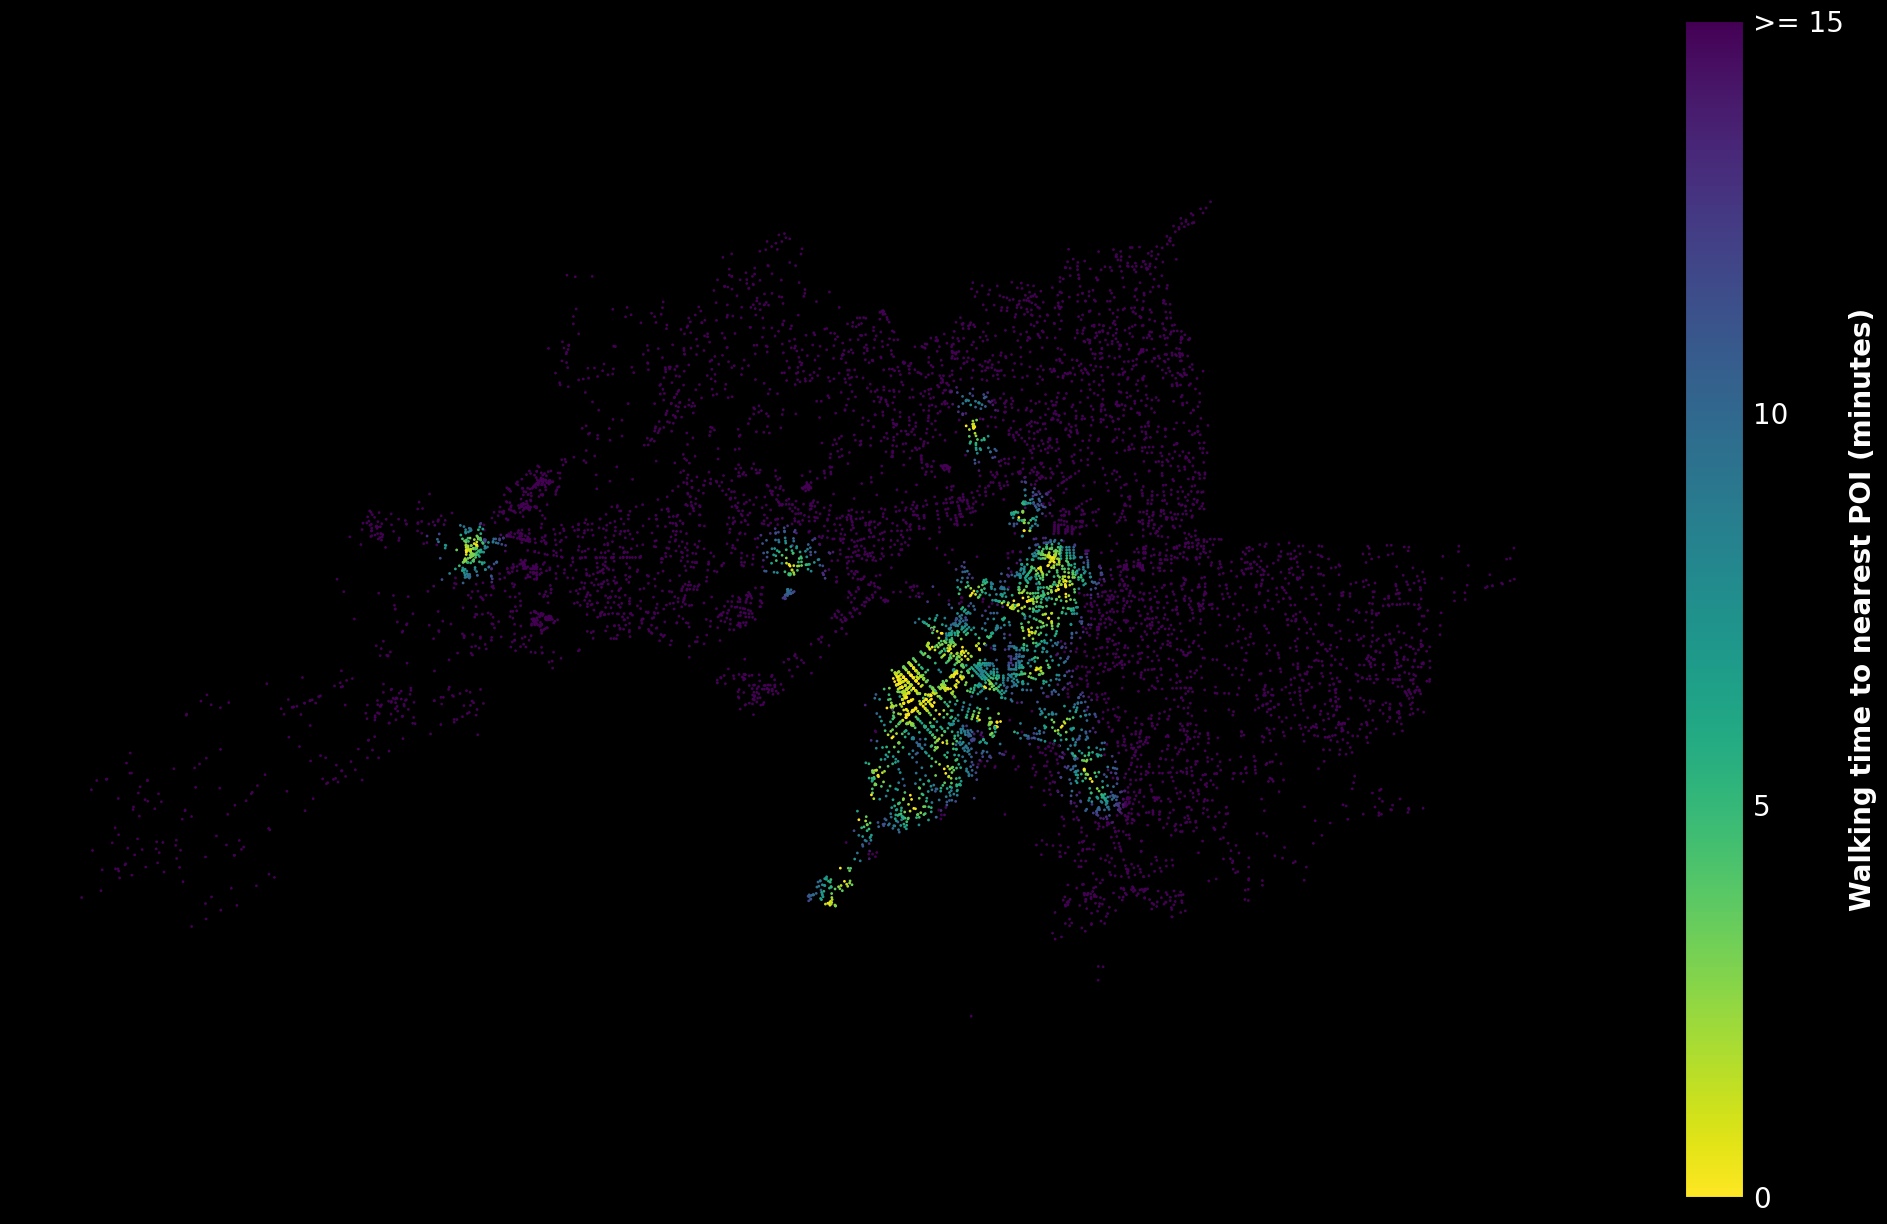

In [20]:
#| echo: false 
#| code-fold: true
# Set text parameters
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor((0,0,0))

# Plot distance to nearest POI
sc = ax.scatter(
    x=nodes['x'],
    y=nodes['y'], 
    c=distances[1],
    s=1,
    cmap='viridis_r',
)

# Colorbar
cb = fig.colorbar(sc, ax=ax, shrink=0.8, ticks=[0, 300, 600, 900])
cb.ax.tick_params(color='none', labelsize=20)
cb.ax.set_yticklabels(['0', '5', '10', '>= 15'])
cb.set_label('Walking time to nearest POI (minutes)', fontsize=20, fontweight='bold')

# Remove empty space
plt.tight_layout()

# Save
plt.savefig('./data/walk_access.png')

The initial visualization was dense; clarity was improved using Matplotlib’s hexbins, this time mapping average walking times per hex. Notably, showing only the nearest POI can be misleading—a tight cluster of amenities could visually equate to an area with a single amenity. Adjusting the metric to, say, the 5th or 10th nearest POI, can provide a more balanced view, as seen in the comparative visualizations.

/var/folders/b2/qx41_qqs0ssddj67gfv4v4kr0000gn/T/ipykernel_24350/1260560219.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


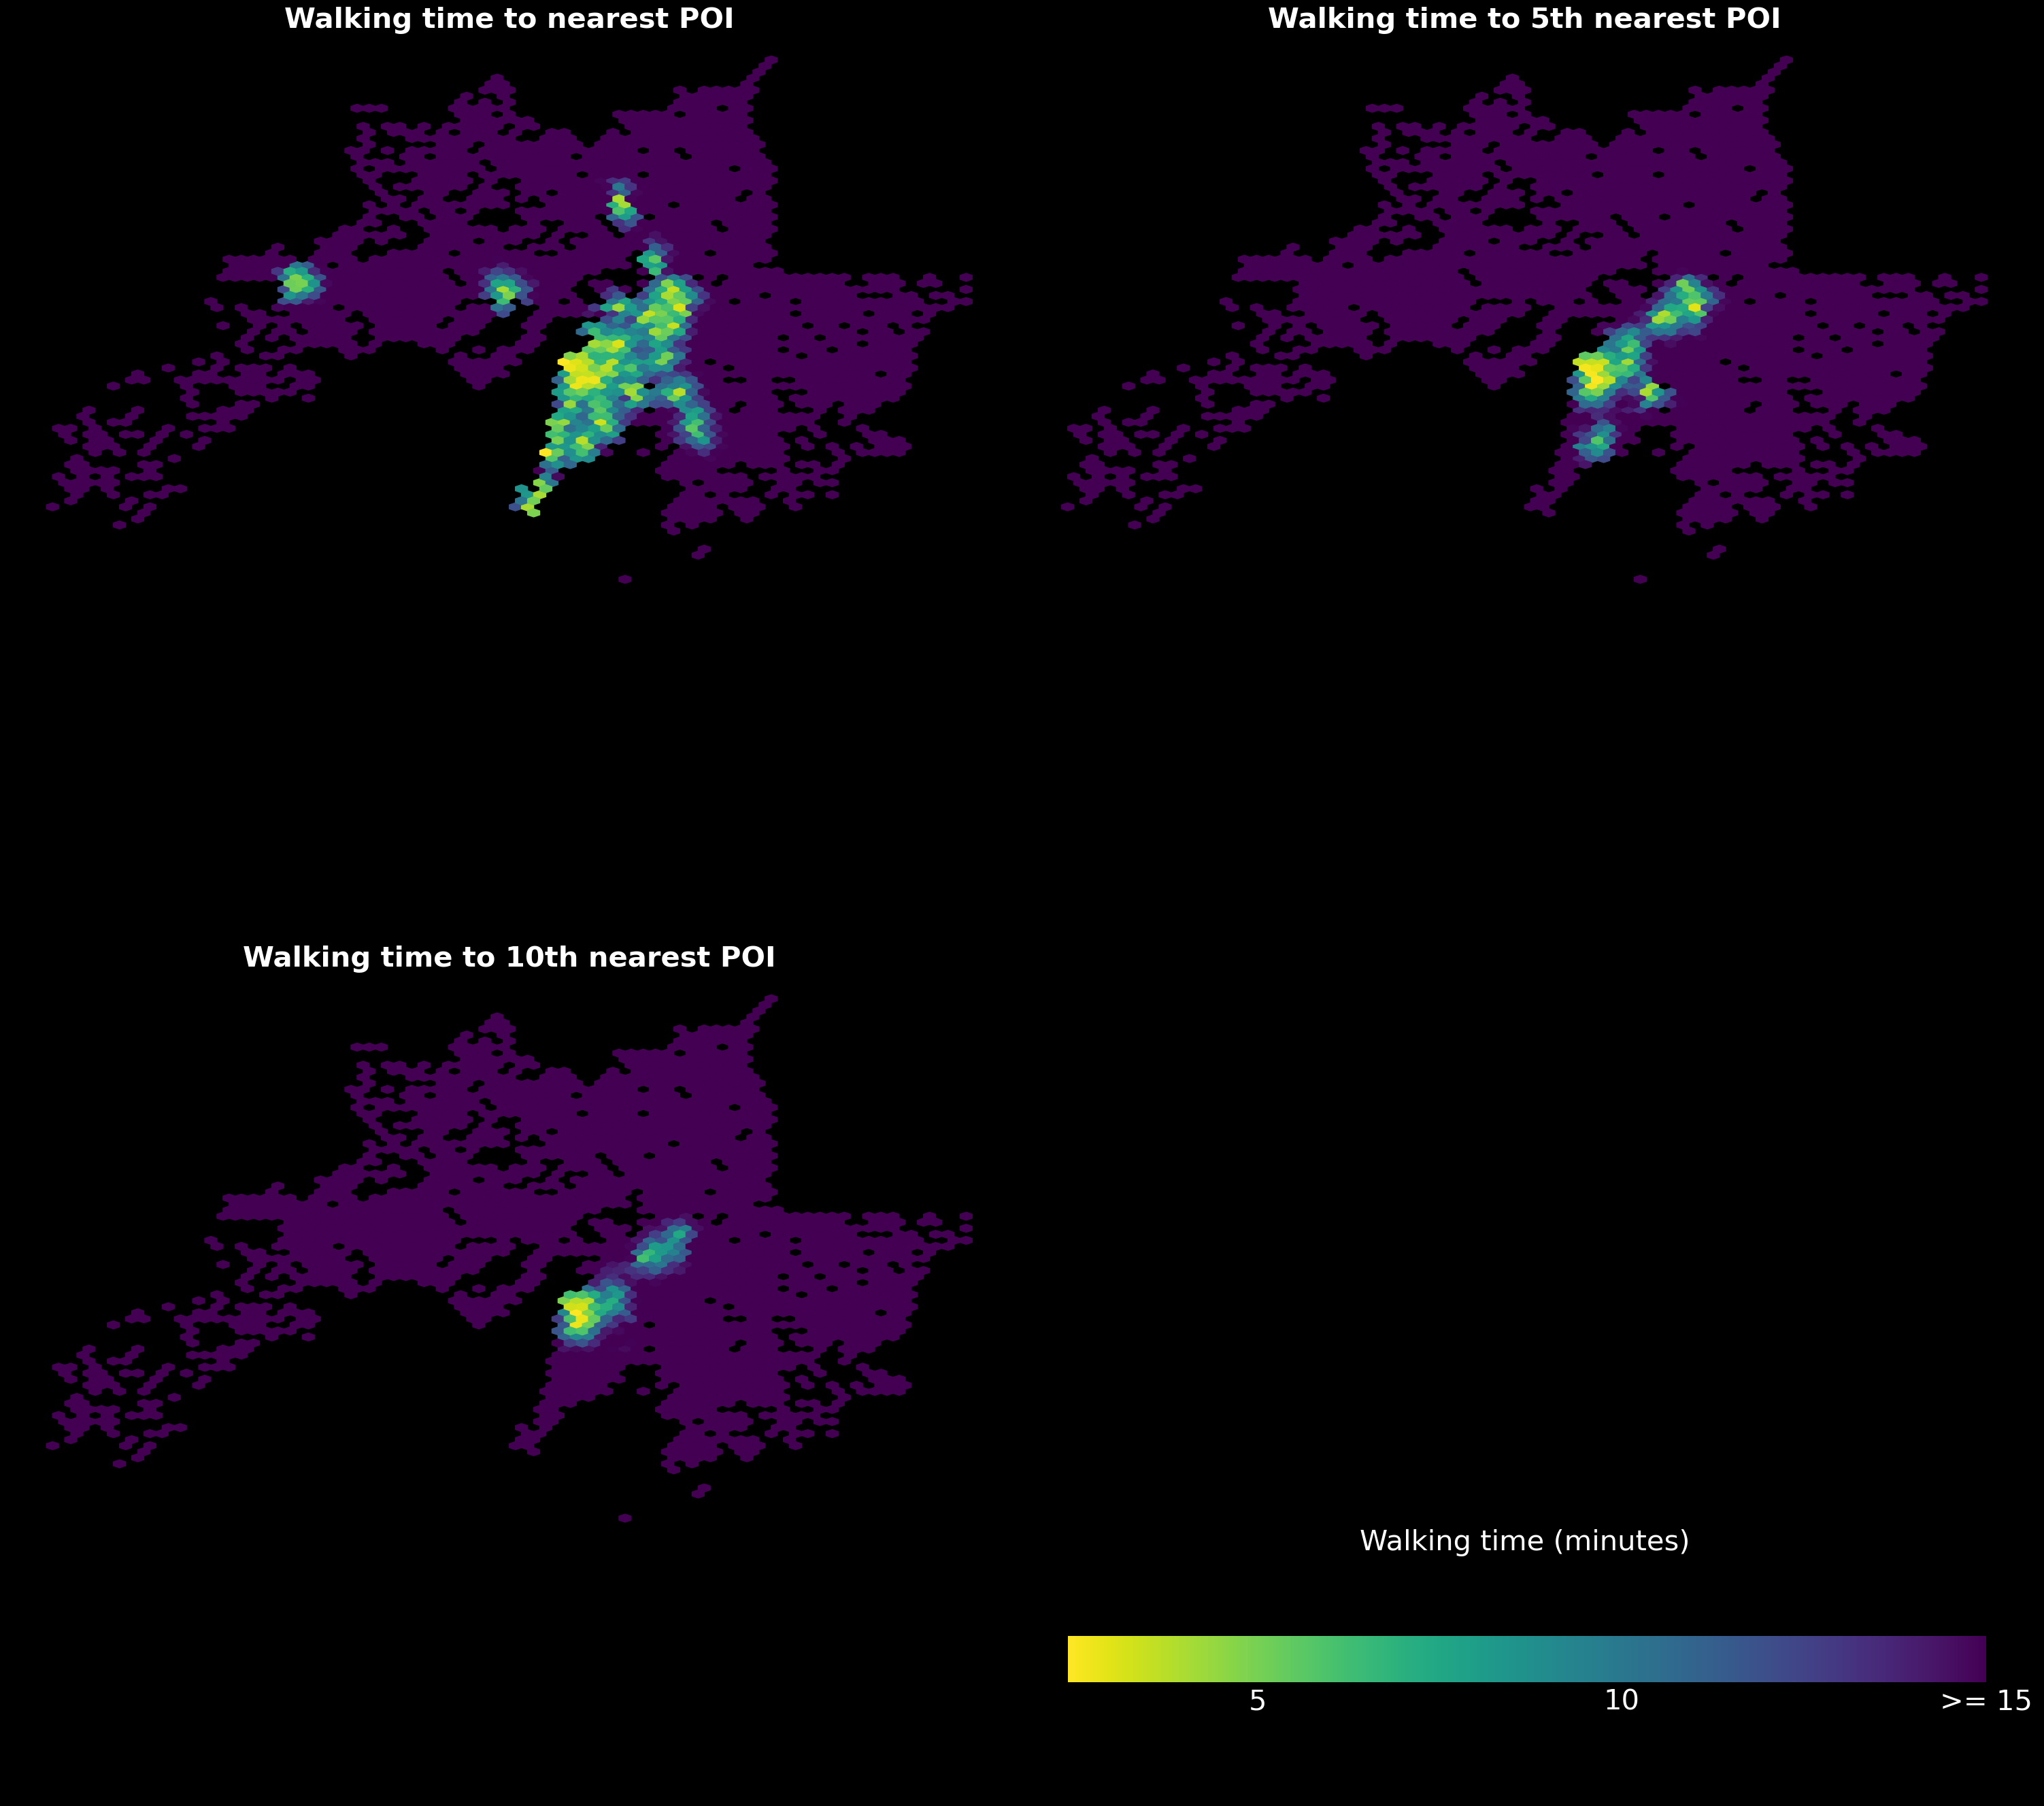

In [21]:
#| echo: false 
#| code-fold: true
# Setup plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30,30), constrained_layout=False)
ax[0][0].set_axis_off()
ax[0][1].set_axis_off()
ax[1][0].set_axis_off()
ax[1][1].set_axis_off()
ax[0][0].set_aspect('equal')
ax[0][1].set_aspect('equal')
ax[1][0].set_aspect('equal')

# Specify colors
fig.set_facecolor('black')
cmap = 'viridis_r'

# Plot distance to nearest POI
hb = ax[0][0].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[1],
    alpha=1
)

# Plot distance to 5th nearest POI
hb = ax[0][1].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[5],
    alpha=1
)

# Plot distance to 10th nearest POI
hb = ax[1][0].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[10],
    alpha=1
)

# Add titles to maps
ax[0][0].set_title('Walking time to nearest POI', fontsize=30, fontweight='bold')
ax[0][1].set_title('Walking time to 5th nearest POI', fontsize=30, fontweight='bold')
ax[1][0].set_title('Walking time to 10th nearest POI', fontsize=30, fontweight='bold')

# Setup color bar axis (location of color bar)
cbar_ax = fig.add_axes([0.5, 0.01, 0.5, 0.5])
cbar_ax.set_axis_off()

# Color bar properties
cb = plt.colorbar(
    hb,
    ax=cbar_ax,
    shrink=0.9,
    ticks=[82, 300, 600, 900],
    orientation='horizontal',
    aspect=20
)
cb.outline.set_edgecolor('none')
cb.ax.tick_params(color='none', labelsize=30)
cb.ax.set_xticklabels(['<= 1', '5', '10', '>= 15'])

# Title for color bar
ax[1][1].text(0.5, 0.23, 'Walking time (minutes)', fontsize=30, ha='center')

# Tight layout
plt.tight_layout()

# Save
plt.savefig('./data/walk_access_comparison.png')

In [22]:
#| echo: true 
#| code-fold: true
# check data
distances.head()

,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
394066125,627.900024,783.099976,900.000000,900.000000,900.000000,900.0,900.0,900.0,900.0,900.0
10230373047,634.200012,789.400024,900.000000,900.000000,900.000000,900.0,900.0,900.0,900.0,900.0
6335457201,586.200012,741.400024,900.000000,900.000000,900.000000,900.0,900.0,900.0,900.0,900.0
6166827034,250.899994,406.100006,900.000000,900.000000,900.000000,900.0,900.0,900.0,900.0,900.0
394072307,220.399994,389.299988,632.200012,635.900024,707.900024,900.0,900.0,900.0,900.0,900.0


In [23]:
#| echo: true 
#| code-fold: true
nodes.head()

,x,y
osmid,,
394066125,698732.530899,-12599.765594
10230373047,698727.899994,-12593.495188
6335457201,698755.517259,-12649.905862
6166827034,699003.214915,-12983.410248
394072307,695563.344670,-9783.976847


In [24]:
#| echo: true 
#| code-fold: true
# Get nodes with wgs coords for output csv
graph_wgs = ox.projection.project_graph(graph, to_crs=32636)
nodes_wgs = ox.graph_to_gdfs(graph_wgs, edges=False)[['x', 'y']]

In [25]:
#| echo: true 
#| code-fold: true
# Join travel time info to nodes
walk_access = nodes.join(distances, on='osmid', how='left')
walk_access_wgs = nodes_wgs.join(distances, on='osmid', how='left')

In [26]:
#| echo: true 
#| code-fold: true
walk_access_wgs.head()

,x,y,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,,,
394066125,698732.530899,-12599.765594,627.900024,783.099976,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0
10230373047,698727.899994,-12593.495188,634.200012,789.400024,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0
6335457201,698755.517259,-12649.905862,586.200012,741.400024,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0
6166827034,699003.214915,-12983.410248,250.899994,406.100006,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0
6335457193,698431.273645,-12430.697247,900.000000,900.000000,900.0,900.0,900.0,900.0,900.0,900.0,900.0,900.0


In [27]:
#| echo: true 
#| code-fold: true
# Save as CSV
walk_access_wgs.to_csv('./data/walk_access.csv', encoding='utf-8')